In [ ]:
# This notebook is to make Figure 1 of Rodgers et al. 2021 (https://doi.org/10.5194/esd-2021-50). 
# If you have have any questions, please contact the author of this notebook.
# Author: Ryohei Yamaguchi (ryamaguchi  at  pusan.ac.kr)

In [1]:
#mpirun --np 6 dask-mpi --scheduler-file scheduler.json --no-nanny --dashboard-address :8785 --memory-limit=60e9
from dask.distributed import Client, LocalCluster
client = Client(scheduler_file='/proj/ryamaguchi/Dask/run_2/scheduler.json')
client

Client Scheduler: tcp://203.247.189.225:37195 Dashboard: http://203.247.189.225:8786/status,Cluster Workers: 5 Cores: 90 Memory: 300.00 GB


### Import

In [1]:
%matplotlib inline

import glob

import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import cmocean
import cmaps

import gsw

from tqdm.notebook import tqdm_notebook

from datetime import datetime
today = datetime.today()

from pyhdf.SD import SD, SDC

import os
import csv

### TREFHT

In [2]:
#Download from: https://crudata.uea.ac.uk/cru/data/temperature/
ds_obs=xr.open_dataset('/proj/ryamaguchi/Observations/SST/HadCRUT4/HadCRUT.4.6.0.0.median.nc')
ds_obs_base=xr.open_dataset('/proj/ryamaguchi/Observations/SST/HadCRUT4/absolute.nc')
ts_obs=(ds_obs.temperature_anomaly.weighted(np.cos(np.deg2rad(ds_obs.latitude)))).mean(('latitude','longitude'))
base=ds_obs_base.tem.weighted(np.cos(np.deg2rad(ds_obs_base.lat))).mean(('lat','lon'))

In [3]:
ts_obs.sel(time=slice(str(1850),str(2019)))

<xarray.DataArray 'temperature_anomaly' (time: 2040)>
array([-0.7249268 , -0.24602538, -0.7245339 , ...,  0.77874726,
        0.70314187,  0.89421326], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2019-12-16T12:00:00

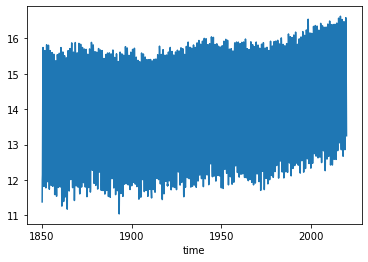

In [4]:
ts_hadc=xr.DataArray((np.tile(base,2040//12)+ts_obs.sel(time=slice(str(1850),str(2019))).values),
                   dims=['time'],coords=[xr.cftime_range(start='1850-01-01',end='2019-12-31',freq='1M',calendar='noleap')])
ts_hadc.plot()
plt.show()

In [5]:
UC=1.

da_w=UC*ts_hadc

vname='TS'
out_dir='/proj/ryamaguchi/CESM2_LENS/time.series/obs/'
fn=today.strftime("%y%m%d")+'_global.TS.HadCRUT4.nc'

da_w.name=vname
ds_w=da_w.to_dataset()
ds_w[vname].attrs['units']="deg C"
ds_w[vname].attrs['long_name']="Global weighted mean TS"
#ds_w[vname].attrs['_FillValue']   =ds[vname].encoding['_FillValue']
#ds_w[vname].attrs['missing_value']=ds[vname].encoding['missing_value']
ds_w.attrs['history']="script path: %s, made by ryamaguchi" %(os.getcwd())

ds_w.to_netcdf(path=out_dir+fn, mode="w",format="NETCDF4_CLASSIC" )
ds_w

<xarray.Dataset>
Dimensions:  (time: 2040)
Coordinates:
  * time     (time) object 1850-01-31 00:00:00 ... 2019-12-31 00:00:00
Data variables:
    TS       (time) float32 11.38 12.0 12.15 13.29 ... 15.82 14.87 13.73 13.25
Attributes:
    history:  script path: /mnt/lustre/proj/ryamaguchi/03.prj_cl/pp/Fig.1, ma...

### TOA

In [10]:
# Download from: https://ceres.larc.nasa.gov/data/
ds=xr.open_dataset('/proj/ryamaguchi/Observations/TOA/CERES_EBAF-TOA_Ed4.1_Subset_200003-202012.nc')
ds

<xarray.Dataset>
Dimensions:            (lat: 180, lon: 360, time: 250)
Coordinates:
  * lon                (lon) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * lat                (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time               (time) datetime64[ns] 2000-03-15 ... 2020-12-15
Data variables:
    toa_sw_all_mon     (time, lat, lon) float32 ...
    toa_lw_all_mon     (time, lat, lon) float32 ...
    toa_net_all_mon    (time, lat, lon) float32 ...
    toa_sw_clr_c_mon   (time, lat, lon) float32 ...
    toa_lw_clr_c_mon   (time, lat, lon) float32 ...
    toa_net_clr_c_mon  (time, lat, lon) float32 ...
Attributes:
    title:        CERES EBAF (Energy Balanced and Filled) TOA Fluxes. Monthly...
    institution:  NASA/LaRC (Langley Research Center) Hampton, Va
    Conventions:  CF-1.4
    comment:      Climatology from 07/2005 to 06/2015
    version:      Edition 4.1; Release Date May 28, 2019
    DOI:          10.5067/TERRA-AQUA/CERES/EBAF-TOA_L3B004.1

In [11]:
time_new=xr.cftime_range(start='2000-03-15',end='2020-12-31',freq='1M',calendar='noleap')
ds = ds.assign_coords(time=time_new)
ds

<xarray.Dataset>
Dimensions:            (lat: 180, lon: 360, time: 250)
Coordinates:
  * lon                (lon) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * lat                (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time               (time) object 2000-03-31 00:00:00 ... 2020-12-31 00:00:00
Data variables:
    toa_sw_all_mon     (time, lat, lon) float32 ...
    toa_lw_all_mon     (time, lat, lon) float32 ...
    toa_net_all_mon    (time, lat, lon) float32 ...
    toa_sw_clr_c_mon   (time, lat, lon) float32 ...
    toa_lw_clr_c_mon   (time, lat, lon) float32 ...
    toa_net_clr_c_mon  (time, lat, lon) float32 ...
Attributes:
    title:        CERES EBAF (Energy Balanced and Filled) TOA Fluxes. Monthly...
    institution:  NASA/LaRC (Langley Research Center) Hampton, Va
    Conventions:  CF-1.4
    comment:      Climatology from 07/2005 to 06/2015
    version:      Edition 4.1; Release Date May 28, 2019
    DOI:          10.5067/TERRA-AQUA/CERES/EBAF-TOA_L3B004.1

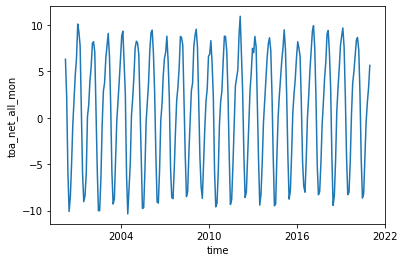

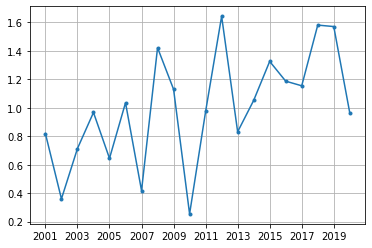

In [12]:
ts=(ds.toa_net_all_mon.weighted(np.cos(np.deg2rad(ds.lat)))).mean(('lat','lon'))
ts.plot()
plt.show()
plt.plot(np.arange(2001,2021),ts.groupby('time.year').mean().isel(year=slice(1,21)),marker='.')
plt.xticks(np.arange(2001,2021,2))
plt.grid()
plt.show()

In [13]:
UC=1.

da_w=UC*ts.sel(time=slice(str(2001),str(2020)))

vname='toa_net_all_mon'
out_dir='/proj/ryamaguchi/CESM2_LENS/time.series/obs/'
fn=today.strftime("%y%m%d")+'_global.TOA.CERES-EBAF.nc'

da_w.name=vname
ds_w=da_w.to_dataset()
ds_w[vname].attrs['units']="W m-2"
ds_w[vname].attrs['long_name']="Global weighted mean toa_net_all"
#ds_w[vname].attrs['_FillValue']   =ds[vname].encoding['_FillValue']
#ds_w[vname].attrs['missing_value']=ds[vname].encoding['missing_value']
ds_w.attrs['history']="script path: %s, made by ryamaguchi" %(os.getcwd())

ds_w.to_netcdf(path=out_dir+fn, mode="w",format="NETCDF4_CLASSIC" )
ds_w

<xarray.Dataset>
Dimensions:          (time: 240)
Coordinates:
  * time             (time) object 2001-01-31 00:00:00 ... 2020-12-31 00:00:00
Data variables:
    toa_net_all_mon  (time) float32 10.09 9.265 7.766 1.218 ... 1.67 3.227 5.642
Attributes:
    history:  script path: /mnt/lustre/proj/ryamaguchi/03.prj_cl/pp/Fig.1, ma...

### Precipitation 

In [18]:
# https://climatedataguide.ucar.edu/climate-data/gpcp-monthly-global-precipitation-climatology-project
ds=xr.open_dataset('/proj/ryamaguchi/Observations/PREC/GPCP_precip.mon.mean.nc')
ds

<xarray.Dataset>
Dimensions:    (lat: 72, lon: 144, nv: 2, time: 505)
Coordinates:
  * lat        (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon        (lon) float32 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-01-01
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) datetime64[ns] ...
    lat_bnds   (lat, nv) float32 ...
    lon_bnds   (lon, nv) float32 ...
    precip     (time, lat, lon) float32 ...
Attributes: (12/18)
    Conventions:           CF-1.0
    curator:               Dr. Jian-Jian Wang\nESSIC, University of Maryland ...
    citation:              Adler, R.F., G.J. Huffman, A. Chang, R. Ferraro, P...
    title:                 GPCP Version 2.3 Combined Precipitation Dataset (F...
    platform:              NOAA POES (Polar Orbiting Environmental Satellites)
    source_obs:            CDR RSS SSMI/SSMIS Tbs over ocean \nCDR SSMI/SSMIS...
    ...                    ...
    source:                https://www.ncei.noaa.gov/data/global-precipitatio...
    source_documentation:  https://www.ncdc.noaa.gov/cdr/atmospheric/precipit...
    NCO:                   4.6.9
    history:               Generated at NOAA/ESRL PSD Sep 9 2016 based on dat...
    References:            http://www.psl.noaa.gov/data/gridded/data.gpcp.html
    data_comment:          Interim data covers 2020/12 through latest.

In [19]:
time_new=xr.cftime_range(start='1979-01-01',end='2021-01-31',freq='1M',calendar='noleap')
ds = ds.assign_coords(time=time_new)
ds

<xarray.Dataset>
Dimensions:    (lat: 72, lon: 144, nv: 2, time: 505)
Coordinates:
  * lat        (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon        (lon) float32 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * time       (time) object 1979-01-31 00:00:00 ... 2021-01-31 00:00:00
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-02-01
    lat_bnds   (lat, nv) float32 -90.0 -87.5 -87.5 -85.0 ... 85.0 87.5 87.5 90.0
    lon_bnds   (lon, nv) float32 0.0 2.5 2.5 5.0 5.0 ... 355.0 357.5 357.5 360.0
    precip     (time, lat, lon) float32 ...
Attributes: (12/18)
    Conventions:           CF-1.0
    curator:               Dr. Jian-Jian Wang\nESSIC, University of Maryland ...
    citation:              Adler, R.F., G.J. Huffman, A. Chang, R. Ferraro, P...
    title:                 GPCP Version 2.3 Combined Precipitation Dataset (F...
    platform:              NOAA POES (Polar Orbiting Environmental Satellites)
    source_obs:            CDR RSS SSMI/SSMIS Tbs over ocean \nCDR SSMI/SSMIS...
    ...                    ...
    source:                https://www.ncei.noaa.gov/data/global-precipitatio...
    source_documentation:  https://www.ncdc.noaa.gov/cdr/atmospheric/precipit...
    NCO:                   4.6.9
    history:               Generated at NOAA/ESRL PSD Sep 9 2016 based on dat...
    References:            http://www.psl.noaa.gov/data/gridded/data.gpcp.html
    data_comment:          Interim data covers 2020/12 through latest.

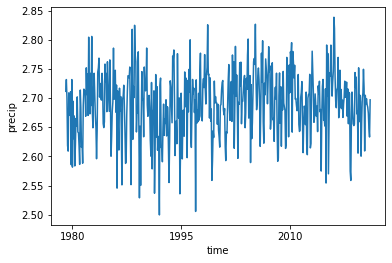

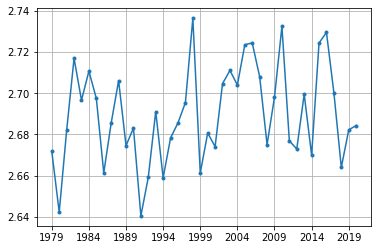

2.689126


In [20]:
ts=(ds.precip.weighted(np.cos(np.deg2rad(ds.lat)))).mean(('lat','lon'))
ts.plot()
plt.show()
plt.plot(np.arange(1979,2021),ts.groupby('time.year').mean().isel(year=slice(0,42)),marker='.')
plt.xticks(np.arange(1979,2021,5))
plt.grid()
plt.show()
print(ts.groupby('time.year').mean().sel(year=slice(1979,2013)).mean('year').values)

In [21]:
UC=1.

da_w=UC*ts.sel(time=slice(str(1979),str(2020)))

vname='PREC'
out_dir='/proj/ryamaguchi/CESM2_LENS/time.series/obs/'
fn=today.strftime("%y%m%d")+'_global.PREC.GPCP.nc'

da_w.name=vname
ds_w=da_w.to_dataset()
ds_w[vname].attrs['units']="mm day-1"
ds_w[vname].attrs['long_name']="Global weighted mean precipitation"
#ds_w[vname].attrs['_FillValue']   =ds[vname].encoding['_FillValue']
#ds_w[vname].attrs['missing_value']=ds[vname].encoding['missing_value']
ds_w.attrs['history']="script path: %s, made by ryamaguchi" %(os.getcwd())

ds_w.to_netcdf(path=out_dir+fn, mode="w",format="NETCDF4_CLASSIC" )
ds_w

<xarray.Dataset>
Dimensions:  (time: 504)
Coordinates:
  * time     (time) object 1979-01-31 00:00:00 ... 2020-12-31 00:00:00
Data variables:
    PREC     (time) float32 2.712 2.732 2.7 2.619 ... 2.685 2.675 2.649 2.634
Attributes:
    history:  script path: /mnt/lustre/proj/ryamaguchi/03.prj_cl/pp/Fig.1, ma...

### ICE

In [1]:
# https://nsidc.org/data/seaice_index

In [33]:
si_n_a=np.zeros([42,12])*np.nan
si_n_e=np.zeros([42,12])*np.nan
for i in range(12) :
    mon=str(i+1).zfill(2)
    with open('/proj/shared_data/obs/NSIDC/SEA.ICE.INDEX/north/N_'+mon+'_extent_v3.0.csv') as f:
        reader = csv.reader(f)
        l = [row for row in reader]
    f.close()
    
    si_n_e[:,i]=np.array(l)[1:43,4].astype('float')
    si_n_a[:,i]=np.array(l)[1:43,5].astype('float')
    
    si_n_e[:,i][si_n_e[:,i]==-9999.]=np.nan
    si_n_a[:,i][si_n_a[:,i]==-9999.]=np.nan
    
xsi_n_e=xr.DataArray(si_n_e.flat,dims=['time'],coords=[xr.cftime_range(start='1979-01-01',end='2020-12-31',freq='1M')])
xsi_n_a=xr.DataArray(si_n_a.flat,dims=['time'],coords=[xr.cftime_range(start='1979-01-01',end='2020-12-31',freq='1M')])

In [34]:
si_s_a=np.zeros([42,12])*np.nan
si_s_e=np.zeros([42,12])*np.nan
for i in range(12) :
    mon=str(i+1).zfill(2)
    with open('/proj/shared_data/obs/NSIDC/SEA.ICE.INDEX/south/S_'+mon+'_extent_v3.0.csv') as f:
        reader = csv.reader(f)
        l = [row for row in reader]
    f.close()
    
    si_s_e[:,i]=np.array(l)[1:43,4].astype('float')
    si_s_a[:,i]=np.array(l)[1:43,5].astype('float')
    
    si_s_e[:,i][si_s_e[:,i]==-9999.]=np.nan
    si_s_a[:,i][si_s_a[:,i]==-9999.]=np.nan
    
xsi_s_e=xr.DataArray(si_s_e.flat,dims=['time'],coords=[xr.cftime_range(start='1979-01-01',end='2020-12-31',freq='1M')])
xsi_s_a=xr.DataArray(si_s_a.flat,dims=['time'],coords=[xr.cftime_range(start='1979-01-01',end='2020-12-31',freq='1M')])

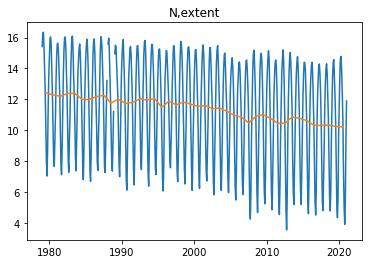

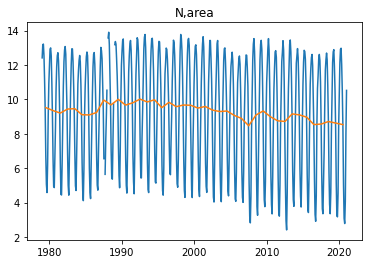

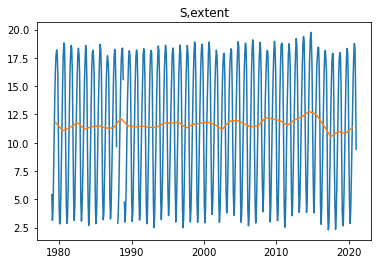

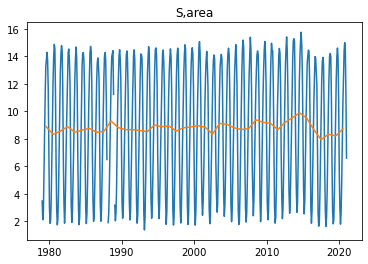

In [35]:
UC=1e-12
plt.plot(np.linspace(1979,2021,12*42),xsi_n_e)
plt.plot(np.arange(1979.5,2021.5),xsi_n_e.groupby('time.year').mean())
plt.title('N,extent')
plt.show()
plt.plot(np.linspace(1979,2021,12*42),xsi_n_a)
plt.plot(np.arange(1979.5,2021.5),xsi_n_a.groupby('time.year').mean())
plt.title('N,area')
plt.show()

plt.plot(np.linspace(1979,2021,12*42),xsi_s_e)
plt.plot(np.arange(1979.5,2021.5),xsi_s_e.groupby('time.year').mean())
plt.title('S,extent')
plt.show()
plt.plot(np.linspace(1979,2021,12*42),xsi_s_a)
plt.plot(np.arange(1979.5,2021.5),xsi_s_a.groupby('time.year').mean())
plt.title('S,area')
plt.show()

In [36]:
UC=1.

da_w=UC*xsi_n_e

vname='aice'
out_dir='/proj/ryamaguchi/CESM2_LENS/time.series/obs/'
fn=today.strftime("%y%m%d")+'_Arctic.ICE_EXTENT.NSIDC-SII.nc'

da_w.name=vname
ds_w=da_w.to_dataset()
ds_w[vname].attrs['units']="10^6 km2"
ds_w[vname].attrs['long_name']="Arctic Sea Ice extent"
#ds_w[vname].attrs['_FillValue']   =ds[vname].encoding['_FillValue']
#ds_w[vname].attrs['missing_value']=ds[vname].encoding['missing_value']
ds_w.attrs['history']="script path: %s, made by ryamaguchi" %(os.getcwd())

ds_w.to_netcdf(path=out_dir+fn, mode="w",format="NETCDF4_CLASSIC" )
ds_w

<xarray.Dataset>
Dimensions:  (time: 504)
Coordinates:
  * time     (time) object 1979-01-31 00:00:00 ... 2020-12-31 00:00:00
Data variables:
    aice     (time) float64 15.41 16.18 16.34 15.45 ... 3.92 5.28 9.35 11.9
Attributes:
    history:  script path: /mnt/lustre/proj/ryamaguchi/03.prj_cl/pp/Fig.1, ma...

In [37]:
UC=1.

da_w=UC*xsi_s_e

vname='aice'
out_dir='/proj/ryamaguchi/CESM2_LENS/time.series/obs/'
fn=today.strftime("%y%m%d")+'_Antarctic.ICE_EXTENT.NSIDC-SII.nc'

da_w.name=vname
ds_w=da_w.to_dataset()
ds_w[vname].attrs['units']="10^6 km2"
ds_w[vname].attrs['long_name']="Antarctic Sea Ice extent"
#ds_w[vname].attrs['_FillValue']   =ds[vname].encoding['_FillValue']
#ds_w[vname].attrs['missing_value']=ds[vname].encoding['missing_value']
ds_w.attrs['history']="script path: %s, made by ryamaguchi" %(os.getcwd())

ds_w.to_netcdf(path=out_dir+fn, mode="w",format="NETCDF4_CLASSIC" )
ds_w

<xarray.Dataset>
Dimensions:  (time: 504)
Coordinates:
  * time     (time) object 1979-01-31 00:00:00 ... 2020-12-31 00:00:00
Data variables:
    aice     (time) float64 5.4 3.14 4.0 7.49 10.83 ... 18.77 18.4 14.99 9.41
Attributes:
    history:  script path: /mnt/lustre/proj/ryamaguchi/03.prj_cl/pp/Fig.1, ma...

### AMOC

In [45]:
#https://rapid.ac.uk/data.php
ds=xr.open_dataset('/proj/ryamaguchi/Observations/AMOC/RAPID_moc_transports.nc')
time_new=xr.cftime_range(start='2004-04-02',end='2018-09-03',freq='12H',calendar='standard')
ds = ds.assign_coords(time=time_new)
ds

<xarray.Dataset>
Dimensions:       (time: 10535)
Coordinates:
  * time          (time) object 2004-04-02 00:00:00 ... 2018-09-03 00:00:00
Data variables:
    t_therm10     (time) float64 ...
    t_aiw10       (time) float64 ...
    t_ud10        (time) float64 ...
    t_ld10        (time) float64 ...
    t_bw10        (time) float64 ...
    t_gs10        (time) float64 ...
    t_ek10        (time) float64 ...
    t_umo10       (time) float64 ...
    moc_mar_hc10  (time) float64 ...
Attributes:
    Title:                         RAPID MOC timeseries
    Institution:                   National Oceanography Centre,UK
    Website:                       http://www.rapid.ac.uk/rapidmoc
    Acknowledgement:               The RAPID-MOC monitoring project is funded...
    Created_by:                    Ben Moat
    Creation_date:                 15-Jul-2020
    Principle_investigator:        Eleanor Frajka-Williams
    Principle_investigator_email:  eleanor.frajka@noc.ac.uk
    DOI:                           doi: 10.5285/aa57e879-4cca-28b6-e053-6c86a...

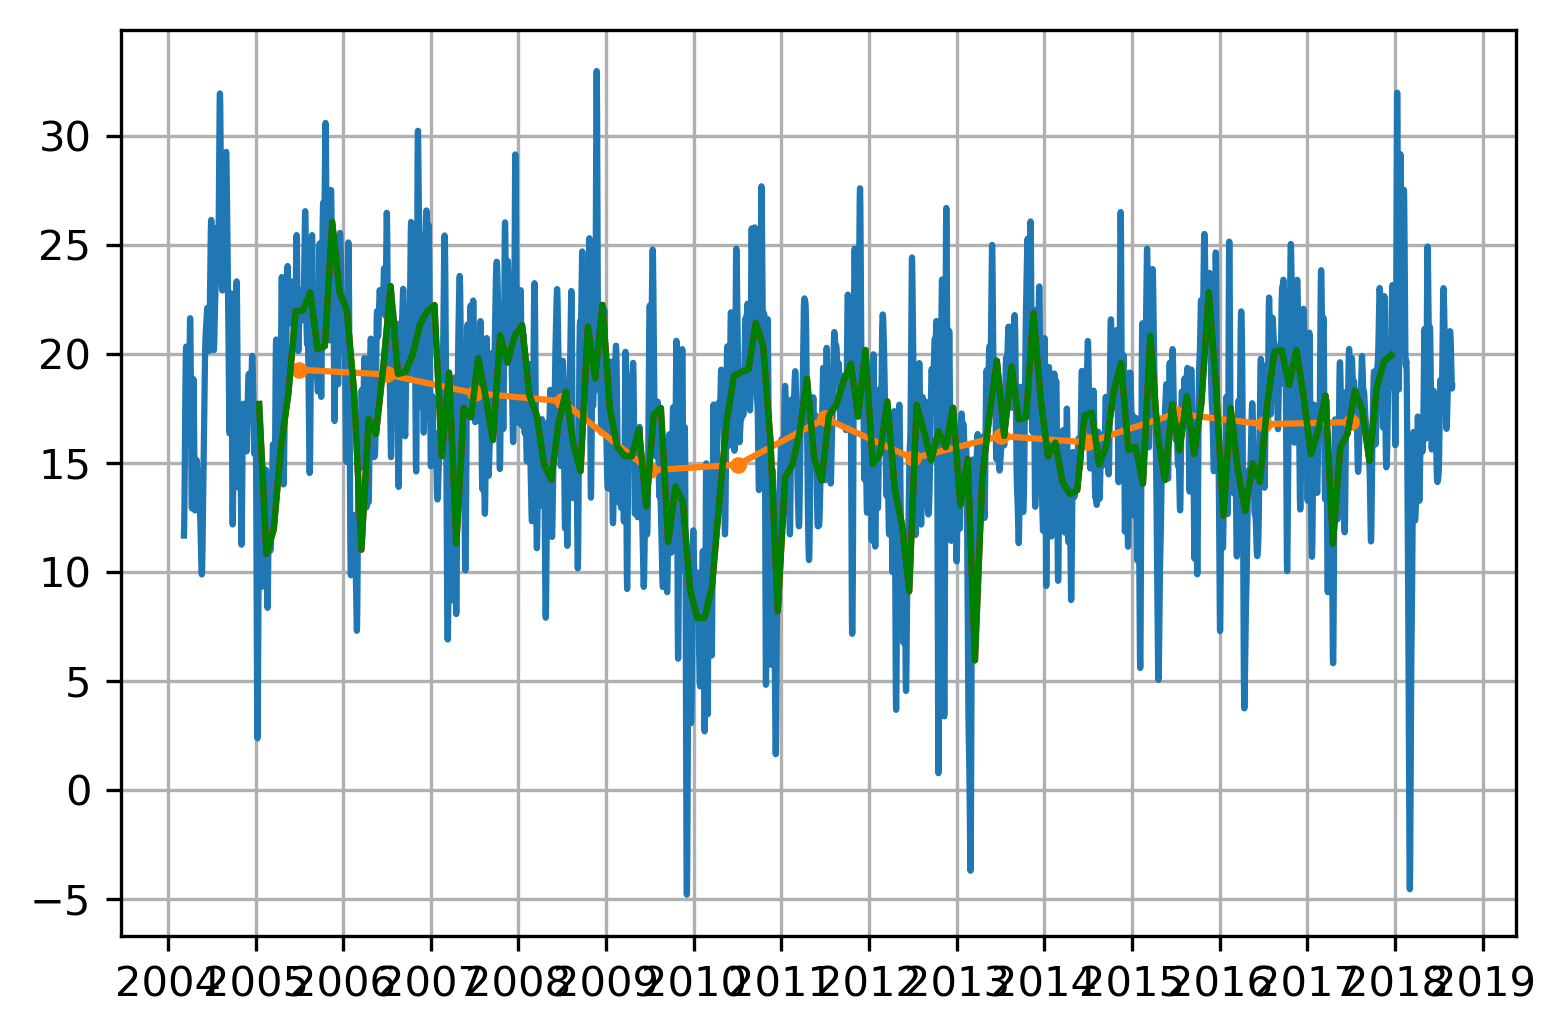

In [46]:
plt.figure(dpi=300)
plt.plot(np.linspace(2004+(62/365),2018+(243/365),10535),ds.moc_mar_hc10)
plt.plot(np.linspace(2005.5,2017.5,13),ds.moc_mar_hc10.sel(time=slice(str(2005),str(2017))).groupby('time.year').mean(),marker='.')
plt.plot(np.linspace(2005+1/24,2018-1/24,13*12),ds.moc_mar_hc10.sel(time=slice(str(2005),str(2017))).resample(time='1M').mean('time'),color='red')
plt.plot(np.linspace(2005+1/24,2018-1/24,13*12),ds.moc_mar_hc10.sel(time=slice(str(2005),str(2017))).resample(time='1MS').mean('time'),color='green')
plt.xticks(np.arange(2004,2020))
plt.grid()
plt.show()

In [47]:
UC=1.

da_w=UC*ds.moc_mar_hc10.sel(time=slice(str(2005),str(2017))).resample(time='1M').mean('time')

vname='moc_mar_hc10'
out_dir='/proj/ryamaguchi/CESM2_LENS/time.series/obs/'
fn=today.strftime("%y%m%d")+'_AMOC.RAPID.nc'

da_w.name=vname
ds_w=da_w.to_dataset()
ds_w[vname].attrs['units']="Sv"
ds_w[vname].attrs['long_name']="Maximum AMOC transpot at 26.5N"
#ds_w[vname].attrs['_FillValue']   =ds[vname].encoding['_FillValue']
#ds_w[vname].attrs['missing_value']=ds[vname].encoding['missing_value']
ds_w.attrs['history']="script path: %s, made by ryamaguchi" %(os.getcwd())

ds_w.to_netcdf(path=out_dir+fn, mode="w",format="NETCDF4_CLASSIC" )
ds_w

<xarray.Dataset>
Dimensions:       (time: 156)
Coordinates:
  * time          (time) object 2005-01-31 00:00:00 ... 2017-12-31 00:00:00
Data variables:
    moc_mar_hc10  (time) float64 17.7 10.82 11.95 15.77 ... 18.46 19.66 19.95
Attributes:
    history:  script path: /mnt/lustre/proj/ryamaguchi/03.prj_cl/pp/Fig.1, ma...

### OHC

In [2]:
# https://www.data.jma.go.jp/gmd/kaiyou/english/ohc/ohc_data_en.html

In [96]:
files=('1955_1959','1960_1969','1970_1979','1980_1989','1990_1999','2000_2009','2010_2019','2020_last')

In [138]:
ohc=np.zeros([66,180,360])*np.nan
err=np.zeros([66,180,360])*np.nan

for i,file in enumerate(files) :    
    nyr=10
    syr=(i-1)*10+5
    if file=='1955_1959': nyr,syr=5,0
    if file=='2020_last': nyr=1
    data=np.loadtxt('/proj/shared_data/obs/Ishii2017/ohc_'+file,dtype='float',comments='#',skiprows=0)
    erro=np.loadtxt('/proj/shared_data/obs/Ishii2017/ohc_err_'+file,dtype='float',comments='#',skiprows=0)
    
    data=data.reshape([nyr,180,360])
    erro=erro.reshape([nyr,180,360])
    data[data==-9.9999]=np.nan
    erro[erro==-9.9999]=np.nan
    ohc[syr:syr+nyr,:,:]=data
    err[syr:syr+nyr,:,:]=erro
    
xohc=xr.DataArray(ohc[:,::-1,:],coords=[xr.cftime_range(start='1955',end='2021',freq='AS-JUL',calendar='noleap'),np.arange(0.5,180),np.arange(0.5,360)],dims=['time','lat','lon'])
xerr=xr.DataArray(err[:,::-1,:],coords=[xr.cftime_range(start='1955',end='2021',freq='AS-JUL',calendar='noleap'),np.arange(0.5,180),np.arange(0.5,360)],dims=['time','lat','lon'])

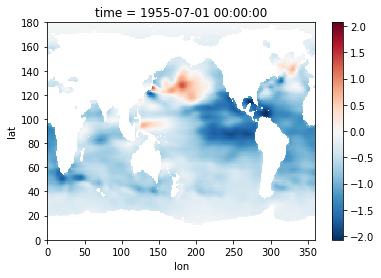

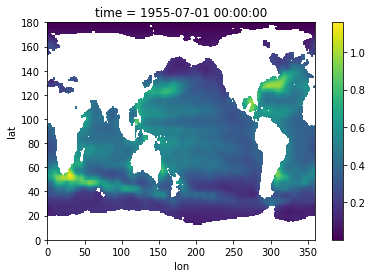

In [139]:
xohc.isel(time=0).plot()
plt.show()
xerr.isel(time=0).plot()
plt.show()

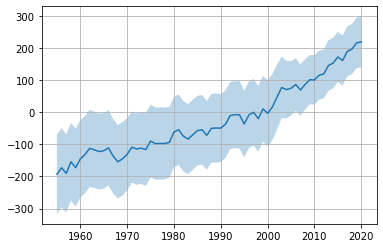

In [140]:
plt.plot(np.arange(1955,2021),xohc.sum(('lat','lon'),skipna=True)*1e-2) #1981-2010
plt.fill_between(np.arange(1955,2021),
                 xohc.sum(('lat','lon'),skipna=True)*1e-2-xerr.sum(('lat','lon'),skipna=True)*1e-2,
                 xohc.sum(('lat','lon'),skipna=True)*1e-2+xerr.sum(('lat','lon'),skipna=True)*1e-2,alpha=0.3,linewidth=0) #1981-2010
plt.grid()
plt.show()

In [141]:
UC =1e-2

da_w=UC*xohc.sum(('lat','lon'),skipna=True)

vname='OHC_2000'
out_dir='/proj/ryamaguchi/CESM2_LENS/time.series/obs/'
fn=today.strftime("%y%m%d")+'_global.OHC_2000.Ishii2017.nc'

da_w.name=vname
ds_w=da_w.to_dataset()
ds_w[vname].attrs['units']="ZJ"
ds_w[vname].attrs['long_name']="Upper 2000m OHC"
#ds_w[vname].attrs['_FillValue']   =ds[vname].encoding['_FillValue']
#ds_w[vname].attrs['missing_value']=ds[vname].encoding['missing_value']
ds_w.attrs['history']="script path: %s, made by ryamaguchi" %(os.getcwd())

ds_w.to_netcdf(path=out_dir+fn, mode="w",format="NETCDF4_CLASSIC" )
ds_w

<xarray.Dataset>
Dimensions:   (time: 66)
Coordinates:
  * time      (time) object 1955-07-01 00:00:00 ... 2020-07-01 00:00:00
Data variables:
    OHC_2000  (time) float64 -193.2 -172.8 -190.4 -154.3 ... 197.1 216.5 219.8
Attributes:
    history:  script path: /mnt/lustre/proj/ryamaguchi/03.prj_cl/pp/Fig.1, ma...